# Analysis of Straddlers

## Setup
### Import Python packages

In [1]:
import pandas as pd
import datadotworld as dw

# local utility functions
from utils import (
    add_fiscal_year,
    set_pd_params,
    tidy_up_df,
    cast_dtypes,
    glue_date_time,
    entirely_within_fiscal_year,
)

from vis_utils import set_plot_params, pointplot_with_barplot

### Set pandas options

In [2]:
set_pd_params()
set_plot_params()
pd.options.mode.chained_assignment = None  # default='warn'

### Import Archibus operational data

In [3]:
kpis_raw = dw.query(
    dataset_key="dgsbpio/auditfinding3", query="select * from wrhwr_02042021"
).dataframe

In [4]:
print(f"The work orders dataframe has {kpis_raw.shape[0]:,} rows.")

kpis_raw.sample(3, random_state=444)[["wr_id", "prob_type", "date_requested"]]

The work orders dataframe has 105,994 rows.


,wr_id,prob_type,date_requested
43021,67692,LAWN,2016-06-15
38037,62755,ELEC/LIGHT,2016-03-03
86771,117819,PLUMB/LEAK,2019-02-27


In [5]:
wr_tidy = cast_dtypes(kpis_raw)
# basic cleaning
wr_tidy = tidy_up_df(wr_tidy)
cond_valid = wr_tidy["status"] != "Can"

wr_valid = wr_tidy[cond_valid]

print(
    f"By dropping canceled work orders, we have removed {len(wr_tidy) - len(wr_valid):,} rows."
)

By dropping canceled work orders, we have removed 3,328 rows.


### Combine date and time columns to get timestamps
This takes the date from a date column and the time from a time column and combines them into a single timestamp.

This transformation allows us to know the time to completion with greater precision. 

In [6]:
# glue the date and time for request
wr_dt = glue_date_time(wr_valid, "date_requested", "time_requested", "requested_dt")

# glue the date and time for completion
wr_dt = glue_date_time(wr_dt, "date_completed", "time_completed", "completed_dt")

# convert "date closed" to a valid datetime (this column has no time information)
wr_dt["date_closed"] = wr_dt["date_closed"].astype("datetime64")

## Analysis

In [7]:
# def entirely_within_fiscal_year(df):
#     df = df.copy().dropna(subset=["date_closed"])
#     # store year and month for both request and closure
#     df["requested_cal_year"] = df["requested_dt"].dt.year
#     df["requested_cal_month"] = df["requested_dt"].dt.month
#     df["closed_cal_year"] = df["date_closed"].dt.year
#     df["closed_cal_month"] = df["date_closed"].dt.month
#     # store the years as numbers
#     y_requested = pd.to_numeric(df["requested_cal_year"])
#     y_closed = pd.to_numeric(df["closed_cal_year"])
#     # compute the fiscal year of request & closure
#     df["requested_fy"] = np.where(
#         df["requested_cal_month"] >= 7, y_requested + 1, y_requested
#     )
#     df["closed_fy"] = np.where(df["closed_cal_month"] >= 7, y_closed + 1, y_closed)
#     # drop the rows that straddle two fiscal years
#     cond_both = df["requested_fy"] == df["closed_fy"]
#     straddler_df = df[~cond_both]
#     non_straddler_df = df[cond_both]
#     straddler_df["is_straddler"] = True
#     non_straddler_df["is_straddler"] = False
#     df = pd.concat([straddler_df, non_straddler_df])
#     df = df.drop(
#         columns=[
#             "requested_cal_year",
#             "requested_cal_month",
#             "closed_cal_year",
#             "closed_cal_month",
#         ]
#     )
#     return df

In [8]:
labeled_df = entirely_within_fiscal_year(wr_dt)

In [9]:
labeled_df[["requested_fy", "closed_fy", "is_straddler"]].sample(6, random_state=444)

,requested_fy,closed_fy,is_straddler
61315,2018,2018,False
68418,2018,2019,True
96990,2020,2020,False
74322,2018,2018,False
25918,2015,2015,False
60052,2017,2020,True


In [10]:
cond_recent = labeled_df["closed_fy"] > 2015
labeled_df = labeled_df[cond_recent]
straddlers_by_fy = labeled_df[["is_straddler", "closed_fy"]].groupby("closed_fy").agg(
    ["mean", "count"]
)

straddlers_by_fy.columns = straddlers_by_fy.columns.droplevel(0)
straddlers_by_fy['mean'] = straddlers_by_fy['mean'] * 100
straddlers_by_fy = straddlers_by_fy.reset_index()
straddlers_by_fy

,closed_fy,mean,count
0,2016,6.651100,14133
1,2017,15.390635,15334
2,2018,12.535663,11216
3,2019,37.312277,6459
4,2020,55.168977,11037
5,2021,69.311718,7032


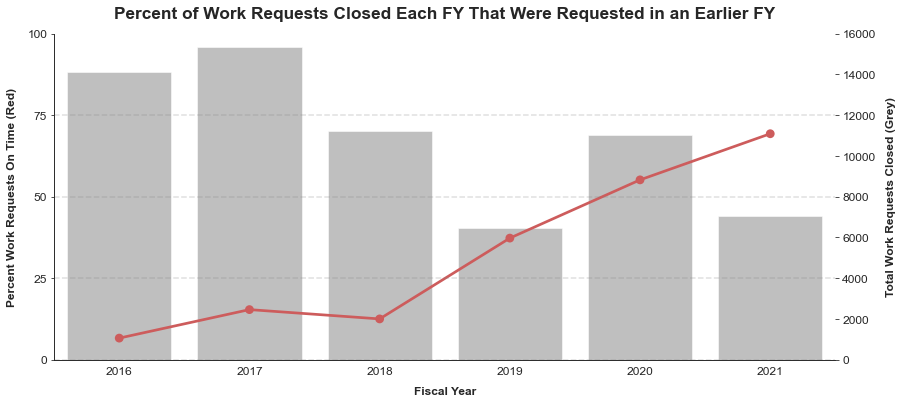

In [11]:
pointplot_with_barplot(
    straddlers_by_fy,
    x="closed_fy",
    point_y="mean",
    bar_y="count",
    ymax_point=100,
    ymax_bar=16_000,
    ylabel_point="Percent Work Requests On Time (Red)",
    ylabel_bar="Total Work Requests Closed (Grey)",
    title="Percent of Work Requests Closed Each FY That Were Requested in an Earlier FY",
)